<a href="https://colab.research.google.com/github/LiamGS/Assignment-3-Classification-and-Localisation/blob/main/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modules Used

In [ ]:
!pip install wandb
!pip install pyyaml h5py 

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

import os
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

import cv2

import wandb
from wandb.keras import WandbCallback

from sklearn.model_selection import train_test_split

In [ ]:
!wandb login

wandb: Currently logged in as: loam (use `wandb login --relogin` to force relogin)


# Import Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
TRAIN_IMG_PATH = '/content/drive/MyDrive/TUKS/Postgraduate/Honours/COS 711/Assignments/Assignment 3/Training_Img/'
TEST_IMG_PATH = '/content/drive/MyDrive/TUKS/Postgraduate/Honours/COS 711/Assignments/Assignment 3/Test_Img/'

In [ ]:
train_df1 = pd.read_csv('/content/drive/MyDrive/TUKS/Postgraduate/Honours/COS 711/Assignments/Assignment 3/Train.csv')
submission_test_df = pd.read_csv('/content/drive/MyDrive/TUKS/Postgraduate/Honours/COS 711/Assignments/Assignment 3/Test.csv')
print(len(train_df1))

train_df1 = train_df1.drop_duplicates(subset=['Image_ID'], keep=False)
print(len(train_df1))

train_df1.head()

3906
2308


,Image_ID,Class,xmin,ymin,width,height
0,ID_007FAIEI,fruit_woodiness,87.0,87.5,228.0,311.0
1,ID_00G8K1V3,fruit_brownspot,97.5,17.5,245.0,354.5
2,ID_00WROUT9,fruit_brownspot,156.5,209.5,248.0,302.5
3,ID_00ZJEEK3,fruit_healthy,125.0,193.0,254.5,217.0
4,ID_018UIENR,fruit_brownspot,79.5,232.5,233.5,182.0


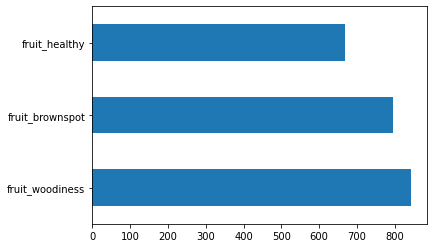

In [ ]:
train_df1.Class.value_counts().plot(kind="barh")

In [ ]:
categories = {'fruit_healthy':0,'fruit_brownspot':1,'fruit_woodiness':2}

train_df2 = train_df1.replace({'Class': categories})

In [ ]:
train_df1.head()

,Image_ID,Class,xmin,ymin,width,height
0,ID_007FAIEI,fruit_woodiness,87.0,87.5,228.0,311.0
1,ID_00G8K1V3,fruit_brownspot,97.5,17.5,245.0,354.5
2,ID_00WROUT9,fruit_brownspot,156.5,209.5,248.0,302.5
3,ID_00ZJEEK3,fruit_healthy,125.0,193.0,254.5,217.0
4,ID_018UIENR,fruit_brownspot,79.5,232.5,233.5,182.0


In [ ]:
train_df2.head()

,Image_ID,Class,xmin,ymin,width,height
0,ID_007FAIEI,2,87.0,87.5,228.0,311.0
1,ID_00G8K1V3,1,97.5,17.5,245.0,354.5
2,ID_00WROUT9,1,156.5,209.5,248.0,302.5
3,ID_00ZJEEK3,0,125.0,193.0,254.5,217.0
4,ID_018UIENR,1,79.5,232.5,233.5,182.0


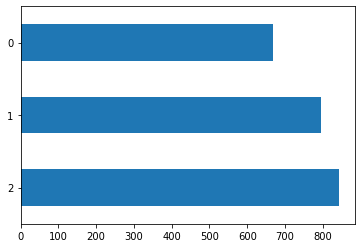

In [ ]:
train_df2.Class.value_counts().plot(kind="barh")

In [ ]:
train_df3 = train_df2.copy()

In [ ]:
train_df3['xmin'] = (train_df3['xmin']/256)-1
train_df3['ymin'] = (train_df3['ymin']/256)-1

In [ ]:
print((train_df3['xmin'][0]+1)*256)
print(train_df2['xmin'][0])

87.0
87.0


# Split Training Data

In [ ]:
train_df, test_df = train_test_split(train_df3, test_size=0.2)

In [ ]:
#For submission purposes 

train_df = train_df3.copy()

In [ ]:
Keys = ['width', 'height']

data_desc = train_df.describe()

for key in Keys:
    train_df[key] = (train_df[key] - data_desc[key][1])/(data_desc[key][2])

    
for key in Keys:
    test_df[key]  = (test_df[key]  - data_desc[key][1])/(data_desc[key][2])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


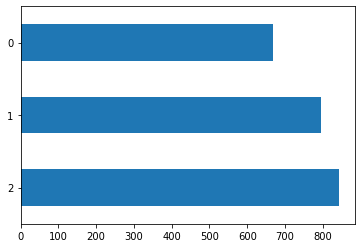

In [ ]:
train_df.Class.value_counts().plot(kind="barh")

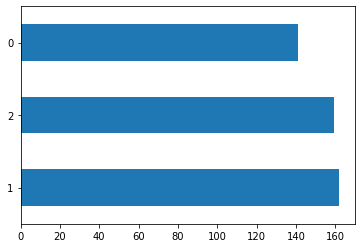

In [ ]:
test_df.Class.value_counts().plot(kind="barh")

In [ ]:
train_image_names = train_df.Image_ID.values
train_labels      = train_df.Class.values
train_bbox        = train_df[['xmin', 'ymin', 'width', 'height']].values

test_image_names  = test_df.Image_ID.values
test_labels       = test_df.Class.values
test_bbox         = test_df[['xmin', 'ymin', 'width', 'height']].values

In [ ]:
#train_image_names_n = train_image_names.copy()
#train_labels_n      = train_labels.copy()
#train_bbox_n        = train_bbox.copy()

In [ ]:
train_labels    = tf.keras.utils.to_categorical(train_labels,3)
#train_labels_n  = tf.keras.utils.to_categorical(train_labels_n,3)
test_labels     = tf.keras.utils.to_categorical(test_labels,3)

In [ ]:
print(train_bbox[0])
train_labels[0]

[-0.66015625 -0.65820312 -0.44544309  1.47678562]


array([0., 0., 1.], dtype=float32)

# Preprocesing

In [ ]:
AUTO            = tf.data.experimental.AUTOTUNE
BATCH_SIZE      = 10

@tf.function
def preprocess_train(image_name, label, bbox):
    image       = tf.io.read_file(TRAIN_IMG_PATH+image_name+'.jpg')
    image       = tf.image.decode_jpeg(image, channels=3)

    return image, {'label': label, 'bbox': bbox}

@tf.function
def preprocess_test(image_name, label, bbox):
    image = tf.io.read_file(TRAIN_IMG_PATH+image_name+'.jpg')
    image = tf.image.decode_jpeg(image, channels=3)

    return image, {'label': label, 'bbox': bbox}

trainloader      = tf.data.Dataset.from_tensor_slices((train_image_names, train_labels, train_bbox))
testloader       = tf.data.Dataset.from_tensor_slices((test_image_names, test_labels, test_bbox))

trainloader = (
    trainloader
    .map(preprocess_train)
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)


testloader = (
    testloader
    .map(preprocess_test)
    .batch(1)
    .prefetch(AUTO)
)

# Define Model

In [ ]:
losses = {'label': 'categorical_crossentropy',
          'bbox': 'huber'}

loss_weights = {'label': 1.0,
                'bbox': 10.0}

In [ ]:
def get_model():
    inputs = Input(shape=(512,512,3), name = "Image Input")
    x = Rescaling(((1./255)-0.5)*2,  name = 'Normalization')(inputs)

    x = Conv2D(256, (3,3), strides = 2, activation='relu')(x)
    x = MaxPooling2D((3,3))(x)
    x = Conv2D(128, (3,3), strides = 2, activation='relu')(x)
    x = MaxPooling2D((3,3))(x)
    x = Conv2D(64, (3,3), strides = 2, activation='relu')(x)
    x = GlobalAveragePooling2D()(x)

    classifier_head = Dense(32, activation='relu')(x)
    classifier_head = Dense(3, activation='softmax', name='label')(classifier_head)

    reg_head = Dense(32, activation='relu')(x)
    reg_head = Dense(4, activation='tanh', name='bbox')(reg_head)

    return Model(inputs=[inputs], outputs=[classifier_head, reg_head])

In [ ]:
tf.keras.backend.clear_session()
model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image Input (InputLayer)       [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 Normalization (Rescaling)      (None, 512, 512, 3)  0           ['Image Input[0][0]']            
                                                                                                  
 conv2d (Conv2D)                (None, 255, 255, 25  7168        ['Normalization[0][0]']          
                                6)                                                                
                                                                                              

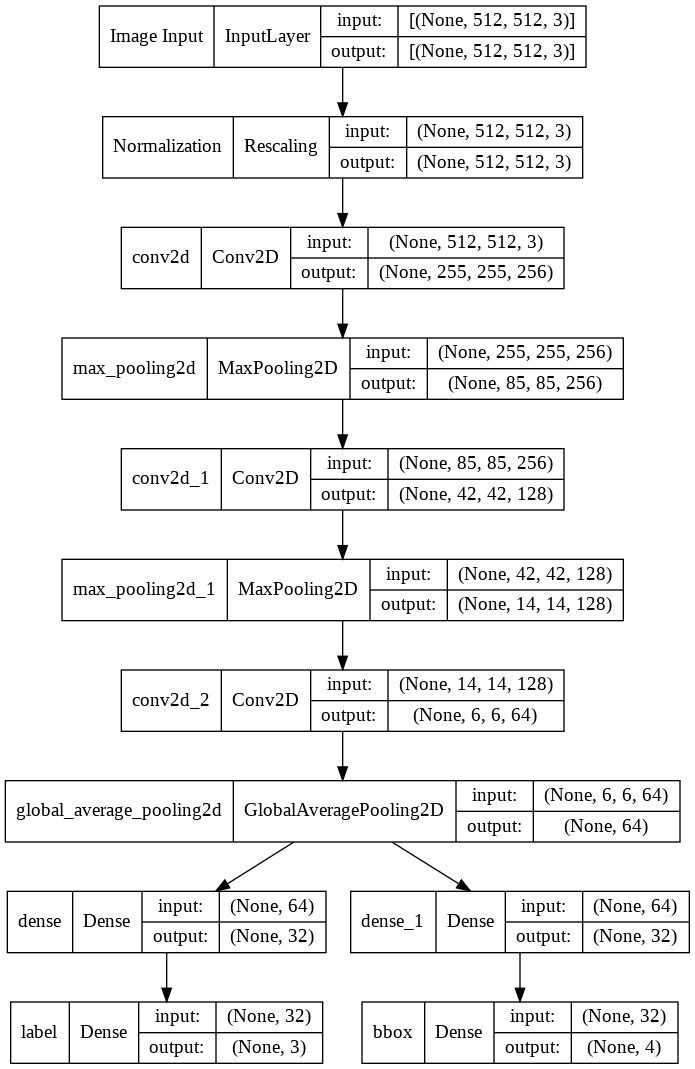

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=True, dpi=96
)

In [ ]:
model.compile('adam', loss=losses, loss_weights=loss_weights, metrics=['acc'])

# Train and Record

In [ ]:
#wandb.init(project='fruit_location_and_labeling_bbox_dropout', job_type='train')

model.fit(trainloader,epochs=40)#,
          #validation_data=testloader),
          #callbacks=[WandbCallback()])

#wandb.finish()

Epoch 1/40
231/231 [==============================] - 37s 141ms/step - loss: 6.0051 - label_loss: 1.8536 - bbox_loss: 0.4151 - label_acc: 0.4302 - bbox_acc: 0.4120
Epoch 2/40
231/231 [==============================] - 36s 141ms/step - loss: 2.8470 - label_loss: 0.8115 - bbox_loss: 0.2035 - label_acc: 0.6495 - bbox_acc: 0.5347
Epoch 3/40
231/231 [==============================] - 36s 140ms/step - loss: 2.5145 - label_loss: 0.6933 - bbox_loss: 0.1821 - label_acc: 0.7067 - bbox_acc: 0.5802
Epoch 4/40
231/231 [==============================] - 36s 141ms/step - loss: 2.2004 - label_loss: 0.5882 - bbox_loss: 0.1612 - label_acc: 0.7565 - bbox_acc: 0.6456
Epoch 5/40
231/231 [==============================] - 35s 139ms/step - loss: 1.8749 - label_loss: 0.5476 - bbox_loss: 0.1327 - label_acc: 0.7838 - bbox_acc: 0.6976
Epoch 6/40
231/231 [==============================] - 36s 140ms/step - loss: 1.7078 - label_loss: 0.4645 - bbox_loss: 0.1243 - label_acc: 0.8098 - bbox_acc: 0.7288
Epoch 7/40
231/2

# Testing for Submission

In [ ]:
AUTO            = tf.data.experimental.AUTOTUNE

def preprocess_test_img(image_name):
    image       = tf.io.read_file(TEST_IMG_PATH+image_name+'.jpg')
    image       = tf.image.decode_jpeg(image, channels=3)

    return image

test_image_ID   = submission_test_df.Image_ID.values
testloader1     = tf.data.Dataset.from_tensor_slices((test_image_ID))

testloader1 = (
    testloader1
    .map(preprocess_test_img)
    .batch(1)
)

In [ ]:
predictions_label, predictions_bbox = model.predict(testloader1)

In [ ]:
classifications = ['fruit_healthy','fruit_brownspot','fruit_woodiness']

In [ ]:
cls = []
con = []
xmi = []
ymi = []
xma = []
yma = []

for i in range(931):
  cls.append(classifications[np.argmax(predictions_label[i])])

  con.append(max(predictions_label[i]))

  xmi.append(round((predictions_bbox[i][0]+1)*256))
  ymi.append(round((predictions_bbox[i][1]+1)*256))

  xma.append(round((predictions_bbox[i][0]+1)*256)+round((predictions_bbox[i][2]*data_desc['width'][2])+data_desc['width'][1]))
  yma.append(round((predictions_bbox[i][1]+1)*256)+round((predictions_bbox[i][3]*data_desc['height'][2])+data_desc['height'][1]))

In [ ]:
test_sub_df = pd.DataFrame({'class':cls,
                            'confidence':con,
                            'ymin':ymi,
                            'xmin':xmi,
                            'ymax':yma,
                            'xmax':xma})

In [ ]:
sub = pd.concat([submission_test_df,test_sub_df],axis=1)

In [ ]:
sub.to_csv('/content/drive/MyDrive/TUKS/Postgraduate/Honours/COS 711/Assignments/Assignment 3/Test/Test.csv', mode='w', index=False, header=True)